In [1]:
import pandas as pd
from pathlib import Path
# Paths
ROOT = Path.cwd().parents[0] if Path.cwd().name == "notebooks" else Path.cwd()
Downloads = ROOT / "Downloads"
store_info = pd.read_csv(Downloads / "store_info.csv")
perf = pd.read_csv(Downloads / "store_performance_2018to2022.csv")
# Cleaning column names
store_info.columns = store_info.columns.str.strip()
perf.columns = perf.columns.str.strip()
# Fixing date types
perf["invoice_date"] = pd.to_datetime(perf["invoice_date"], errors="coerce")
print("Loaded store_info rows:", len(store_info))
print("Loaded perf rows:", len(perf))
print("Stores:", perf["store_id"].nunique())

Loaded store_info rows: 439
Loaded perf rows: 773266
Stores: 439


In [2]:
df = perf.merge(store_info, on="store_id", how="left")
print("Rows after merge:", len(df))
print("Missing latitudes:", df["store_latitude"].isna().sum())
df.head()

Rows after merge: 773266
Missing latitudes: 0


,invoice_date,store_id,invoice_count,oc_count,fleet_oc_count,store_city,store_state,store_zip,bay_count,time_zone_code,closed_day_description,region_id,company_id,market_id,area_id,marketing_area_id,store_latitude,store_longitude
0,2020-03-02,86856,72,59,6,Fairfield,OH,45014,4,EASTERN,NaN,228351,79605,230743,625945,5880,39.33569,-84.52823
1,2020-03-12,601811,91,82,5,Cincinnati,OH,45208,3,EASTERN,NaN,228351,79605,230743,228376,5880,39.14511,-84.44394
2,NaT,230710,32,26,4,Eureka,MO,63025,3,CENTRAL,NaN,228353,79605,230703,230705,5887,38.50603,-90.63588
3,2020-03-07,611647,45,39,0,Newport,OR,97365,2,PACIFIC,NaN,612513,79605,612514,611567,6112,44.65427,-124.05417
4,2020-03-08,99300,35,31,1,Auburn,NY,13021,2,EASTERN,NaN,228356,79605,624466,271031,5886,42.94207,-76.55241


In [3]:
df["dow"] = df["invoice_date"].dt.dayofweek
df["dow_name"] = df["invoice_date"].dt.day_name()
df["year"] = df["invoice_date"].dt.year
df["month"] = df["invoice_date"].dt.month
df["is_weekend"] = (df["dow"] >= 5).astype(int)
df[["invoice_date", "dow_name", "is_weekend"]].head()

,invoice_date,dow_name,is_weekend
0,2020-03-02,Monday,0
1,2020-03-12,Thursday,0
2,NaT,NaN,0
3,2020-03-07,Saturday,1
4,2020-03-08,Sunday,1


In [4]:
# Focus on one year
df_eda = df[df["year"] == 2020]
# Drop rows with invalid dates
df_eda = df_eda.dropna(subset=["invoice_date"])
# Sample stores from clean data
sample_stores = (
    df_eda["store_id"]
    .drop_duplicates()
    .sample(15, random_state=42)
)
df_eda = df_eda[df_eda["store_id"].isin(sample_stores)]
print("EDA stores:", df_eda["store_id"].nunique())
print("EDA rows:", len(df_eda))

EDA stores: 15
EDA rows: 2052


In [5]:
import meteostat
import inspect

print("meteostat version:", meteostat.__version__)
print("\nTop-level attributes:")
print([x for x in dir(meteostat) if not x.startswith("_")])

meteostat version: 2.1.0

Top-level attributes:
['Granularity', 'Inventory', 'License', 'Parameter', 'Point', 'Provider', 'Station', 'TimeSeries', 'UnitSystem', 'api', 'config', 'core', 'daily', 'enumerations', 'hourly', 'interpolate', 'interpolation', 'lapse_rate', 'merge', 'monthly', 'normals', 'parameters', 'providers', 'purge', 'stations', 'typing', 'utils']


In [13]:
from datetime import date
import meteostat as ms
# 1. Define store location (example: Lexington, KY)
point = ms.Point(38.01075, -84.45542)
# 2. Time range
start = date(2018, 1, 1)
end   = date(2022, 12, 31)
# 3. Find nearby stations
stations = ms.stations.nearby(point, limit=5)
# 4. Get daily data from stations
ts = ms.daily(stations, start, end)
# 5. Interpolate to exact store location + fetch dataframe
weather_df = ms.interpolate(ts, point).fetch()
weather_df.head()

,temp,tmin,tmax,rhum,prcp,snwd,wspd,pres,cldc
time,,,,,,,,,
2018-01-01,-11.5,-15.8,-7.7,62,0.0,0,10.6,1038.6,<NA>
2018-01-02,-13.7,-19.2,-6.5,58,0.0,0,4.7,1037.6,0
2018-01-03,-9.0,-15.6,-0.5,53,0.0,0,12.6,1022.9,<NA>
2018-01-04,-8.1,-13.0,-5.1,65,0.0,0,16.0,1022.8,<NA>
2018-01-05,-11.2,-14.9,-7.2,59,0.0,0,8.7,1029.1,<NA>


In [14]:
from datetime import date
import meteostat as ms
import pandas as pd

def get_weather_for_store(lat, lon, start, end, station_limit=5):
    point = ms.Point(lat, lon)  # elevation will be None, that's OK

    stations = ms.stations.nearby(point, limit=station_limit)
    ts = ms.daily(stations, start, end)

    df = ms.interpolate(
        ts,
        point,
        elevation_threshold=None,   # <- prevents NoneType crash
        distance_threshold=None     # optional: you can set like 50000 (meters) later
    ).fetch()

    return df.reset_index()


In [18]:
weather_all = []
failed = []

start = date(2020, 1, 1)
end   = date(2020, 12, 31)

for store_id in df_eda["store_id"].unique():
    store = store_info.loc[store_info["store_id"] == store_id].iloc[0]
    lat = float(store["store_latitude"])
    lon = float(store["store_longitude"])

    try:
        w = get_weather_for_store(lat, lon, start, end, station_limit=5)
        w["store_id"] = store_id
        weather_all.append(w)
    except Exception as e:
        failed.append((store_id, str(e)))

weather_df = pd.concat(weather_all, ignore_index=True)
print("Weather rows:", len(weather_df))
print("Failed stores:", len(failed))
failed[:5]

# --- Merge EDA store data with weather data ---
df_merged = df_eda.merge(
    weather_df,
    left_on=["store_id", "invoice_date"],
    right_on=["store_id", "time"],
    how="left"
)

print("Merged rows:", len(df_merged))
df_merged.head()

Weather rows: 5490
Failed stores: 0
Merged rows: 2052


,invoice_date,store_id,invoice_count,oc_count,fleet_oc_count,store_city,store_state,store_zip,bay_count,time_zone_code,...,time,temp,tmin,tmax,rhum,prcp,snwd,wspd,pres,cldc
0,2020-03-02,603020,42,38,5,New Albany,IN,47150,2,EASTERN,...,2020-03-02,12.4,10.0,15.0,84,12.4,0,17.6,1009.6,<NA>
1,2020-03-01,230659,36,34,0,Massillon,OH,44646,2,EASTERN,...,2020-03-01,-1.2,-7.7,8.9,53,0.0,0,18.4,1019.9,0
2,2020-03-09,614385,38,29,2,Bossier City,LA,71111,3,CENTRAL,...,2020-03-09,17.5,15.6,19.4,79,<NA>,<NA>,17.0,1023.0,<NA>
3,2020-03-05,230659,44,39,3,Massillon,OH,44646,2,EASTERN,...,2020-03-05,3.3,-2.1,10.0,59,0.0,0,11.2,1018.0,0
4,2020-03-10,603020,34,30,2,New Albany,IN,47150,2,EASTERN,...,2020-03-10,12.7,8.0,16.0,84,8.1,0,18.7,1020.3,<NA>


In [19]:
# Inspect weather columns
print("Weather DF columns:")
print(weather_df.columns.tolist())

print("\nMerged DF columns:")
print(df_merged.columns.tolist())

# Safely select weather-related columns that actually exist
wanted = [
    "store_id",
    "invoice_date",
    "invoice_count",
    "tavg",
    "temp",
    "tmin",
    "tmax",
    "prcp",
    "snow",
    "wspd"
]

existing = [c for c in wanted if c in df_merged.columns]
missing = [c for c in wanted if c not in df_merged.columns]

print("\nExisting columns:", existing)
print("Missing columns:", missing)

# Preview only valid columns
df_merged[existing].head()

Weather DF columns:
['time', 'temp', 'tmin', 'tmax', 'rhum', 'prcp', 'snwd', 'wspd', 'pres', 'cldc', 'store_id']

Merged DF columns:
['invoice_date', 'store_id', 'invoice_count', 'oc_count', 'fleet_oc_count', 'store_city', 'store_state', 'store_zip', 'bay_count', 'time_zone_code', 'closed_day_description', 'region_id', 'company_id', 'market_id', 'area_id', 'marketing_area_id', 'store_latitude', 'store_longitude', 'dow', 'dow_name', 'year', 'month', 'is_weekend', 'time', 'temp', 'tmin', 'tmax', 'rhum', 'prcp', 'snwd', 'wspd', 'pres', 'cldc']

Existing columns: ['store_id', 'invoice_date', 'invoice_count', 'temp', 'tmin', 'tmax', 'prcp', 'wspd']
Missing columns: ['tavg', 'snow']


,store_id,invoice_date,invoice_count,temp,tmin,tmax,prcp,wspd
0,603020,2020-03-02,42,12.4,10.0,15.0,12.4,17.6
1,230659,2020-03-01,36,-1.2,-7.7,8.9,0.0,18.4
2,614385,2020-03-09,38,17.5,15.6,19.4,<NA>,17.0
3,230659,2020-03-05,44,3.3,-2.1,10.0,0.0,11.2
4,603020,2020-03-10,34,12.7,8.0,16.0,8.1,18.7


In [20]:
# Create derived weather features (NA-safe)
df_merged = df_merged.copy()
# Make sure weather numeric columns are numeric (sometimes they come as objects)
for c in ["temp", "tmin", "tmax", "prcp", "snwd", "wspd"]:
    if c in df_merged.columns:
        df_merged[c] = pd.to_numeric(df_merged[c], errors="coerce")
# Temperature bins (Celsius)
df_merged["temp_bin"] = pd.cut(
    df_merged["temp"],
    bins=[-30, 0, 10, 20, 30, 50],
    labels=["Freezing", "Cold", "Mild", "Warm", "Hot"]
)
# Rain indicator (treat missing prcp as 0 for this feature)
df_merged["is_rain"] = (df_merged["prcp"].fillna(0) > 0).astype(int)
# Wind bins (handle missing wspd)
df_merged["wind_bin"] = pd.cut(
    df_merged["wspd"],
    bins=[0, 5, 15, 30, 100],
    labels=["Calm", "Breezy", "Windy", "Very Windy"]
)
df_merged[["temp", "temp_bin", "prcp", "is_rain", "wspd", "wind_bin"]].head()

,temp,temp_bin,prcp,is_rain,wspd,wind_bin
0,12.4,Mild,12.4,1,17.6,Windy
1,-1.2,Freezing,0.0,0,18.4,Windy
2,17.5,Mild,<NA>,0,17.0,Windy
3,3.3,Cold,0.0,0,11.2,Breezy
4,12.7,Mild,8.1,1,18.7,Windy


In [21]:
pilot_stores = (
    df_eda[["store_id"]]
    .drop_duplicates()
    .merge(
        store_info[["store_id", "store_latitude", "store_longitude"]],
        on="store_id",
        how="left"
    )
)

print("Pilot stores:", len(pilot_stores))
pilot_stores.head()

Pilot stores: 15


,store_id,store_latitude,store_longitude
0,603020,38.33724,-85.79959
1,230659,40.80073,-81.50776
2,614385,32.54341,-93.70815
3,615904,42.74040,-84.73476
4,96793,43.15132,-76.22993


In [22]:
from tqdm import tqdm
import meteostat as ms
import pandas as pd
from datetime import date

# Date range for EDA (you chose 2020 – perfect)
start_d = date(2020, 1, 1)
end_d   = date(2020, 12, 31)

print("Weather date range:", start_d, "to", end_d)

weather_frames = []

for _, row in tqdm(
    pilot_stores.iterrows(),
    total=len(pilot_stores),
    desc="Meteostat daily"
):
    sid = int(row["store_id"])
    point = ms.Point(float(row["store_latitude"]), float(row["store_longitude"]))

    stations = ms.stations.nearby(point, limit=5)
    ts = ms.daily(stations, start_d, end_d)

    try:
        w = ms.interpolate(ts, point, elevation_threshold=None).fetch()
        if w is None or w.empty:
            print(f"[Skip] {sid}: no data returned")
            continue
    except Exception as e:
        print(f"[Skip] {sid}: {e}")
        continue

    w = w.reset_index().rename(columns={"time": "invoice_date"})
    w["invoice_date"] = pd.to_datetime(w["invoice_date"])
    w["store_id"] = sid

    keep = ["store_id", "invoice_date", "temp", "tmin", "tmax", "prcp", "snwd", "wspd"]
    w = w[[c for c in keep if c in w.columns]]

    weather_frames.append(w)

weather_df = pd.concat(weather_frames, ignore_index=True)
print("Stores fetched:", weather_df["store_id"].nunique())
weather_df.head()


Weather date range: 2020-01-01 to 2020-12-31


Meteostat daily: 100%|██████████████████████████████████████████████████████████████████████████████| 15/15 [01:16<00:00,  5.09s/it]

Stores fetched: 15


,store_id,invoice_date,temp,tmin,tmax,prcp,snwd,wspd
0,603020,2020-01-01,5.3,2.2,10.6,0.0,0,14.8
1,603020,2020-01-02,8.3,6.7,13.3,5.8,0,13.3
2,603020,2020-01-03,12.0,10.0,13.3,17.8,0,9.7
3,603020,2020-01-04,6.9,2.8,10.0,1.5,0,21.2
4,603020,2020-01-05,4.0,-1.0,11.1,0.0,0,16.9


In [28]:
# Merge weather with store performance EDA
weather_df = weather_df.rename(columns={"time": "invoice_date"})
weather_df["invoice_date"] = pd.to_datetime(weather_df["invoice_date"])

df_merged = df_eda.merge(
    weather_df,
    on=["store_id", "invoice_date"],
    how="left"
)

df_merged.head()

,invoice_date,store_id,invoice_count,oc_count,fleet_oc_count,store_city,store_state,store_zip,bay_count,time_zone_code,...,dow_name,year,month,is_weekend,temp,tmin,tmax,prcp,snwd,wspd
0,2020-03-02,603020,42,38,5,New Albany,IN,47150,2,EASTERN,...,Monday,2020.0,3.0,0,12.5,10.0,15.2,12.4,0,17.6
1,2020-03-01,230659,36,34,0,Massillon,OH,44646,2,EASTERN,...,Sunday,2020.0,3.0,1,-0.3,-7.4,8.9,0.0,0,16.8
2,2020-03-09,614385,38,29,2,Bossier City,LA,71111,3,CENTRAL,...,Monday,2020.0,3.0,0,17.5,15.6,19.4,<NA>,<NA>,17.0
3,2020-03-05,230659,44,39,3,Massillon,OH,44646,2,EASTERN,...,Thursday,2020.0,3.0,0,3.2,-2.9,10.3,0.0,0,9.4
4,2020-03-10,603020,34,30,2,New Albany,IN,47150,2,EASTERN,...,Tuesday,2020.0,3.0,0,13.0,8.0,16.1,8.1,0,18.7


In [29]:
# Create derived weather features (NA-safe)
import pandas as pd

df_merged = df_merged.copy()

# Ensure numeric
for c in ["temp", "tmin", "tmax", "prcp", "snwd", "wspd"]:
    if c in df_merged.columns:
        df_merged[c] = pd.to_numeric(df_merged[c], errors="coerce")

# Temperature bins (Celsius)
df_merged["temp_bin"] = pd.cut(
    df_merged["temp"],
    bins=[-30, 0, 10, 20, 30, 50],
    labels=["Freezing", "Cold", "Mild", "Warm", "Hot"]
)

# Rain indicator (treat missing as no rain)
df_merged["is_rain"] = (df_merged["prcp"].fillna(0) > 0).astype(int)

df_merged[["temp", "temp_bin", "prcp", "is_rain"]].head()

,temp,temp_bin,prcp,is_rain
0,12.5,Mild,12.4,1
1,-0.3,Freezing,0.0,0
2,17.5,Mild,<NA>,0
3,3.2,Cold,0.0,0
4,13.0,Mild,8.1,1


C:\Users\harsh\AppData\Local\Temp\ipykernel_40716\3552303711.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby("temp_bin")["invoice_count"]


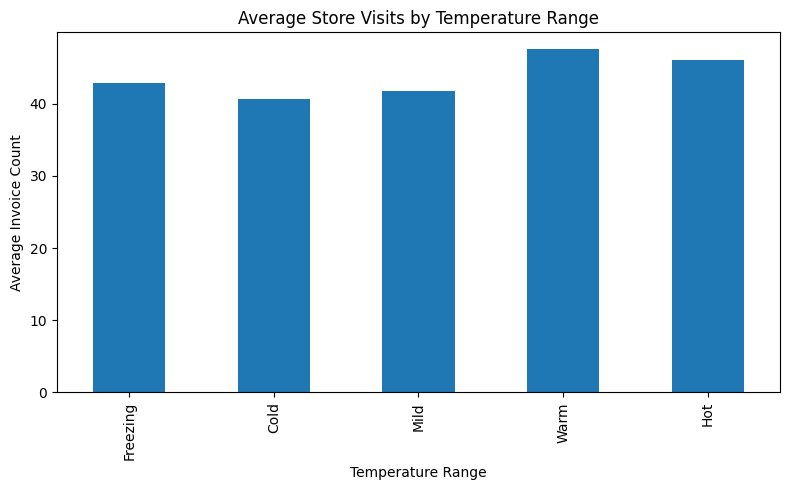

In [30]:
import matplotlib.pyplot as plt

temp_plot = (
    df_merged
    .groupby("temp_bin")["invoice_count"]
    .mean()
)

plt.figure(figsize=(8,5))
temp_plot.plot(kind="bar")
plt.title("Average Store Visits by Temperature Range")
plt.xlabel("Temperature Range")
plt.ylabel("Average Invoice Count")
plt.tight_layout()
plt.show()

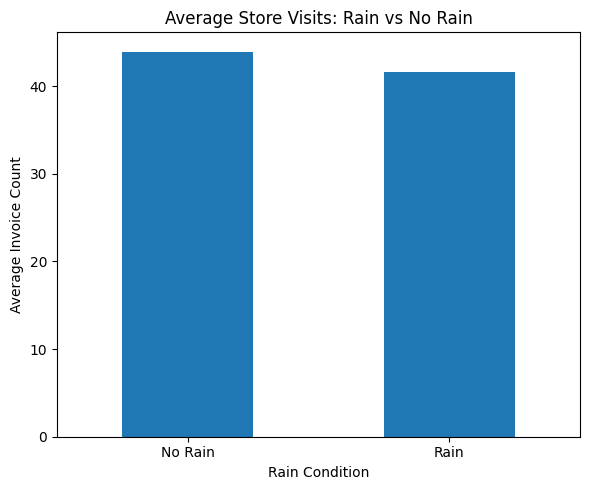

In [31]:
rain_plot = (
    df_merged
    .groupby("is_rain")["invoice_count"]
    .mean()
)
plt.figure(figsize=(6,5))
rain_plot.plot(kind="bar")
plt.title("Average Store Visits: Rain vs No Rain")
plt.xlabel("Rain Condition")
plt.ylabel("Average Invoice Count")
plt.xticks([0,1], ["No Rain", "Rain"], rotation=0)
plt.tight_layout()
plt.show()

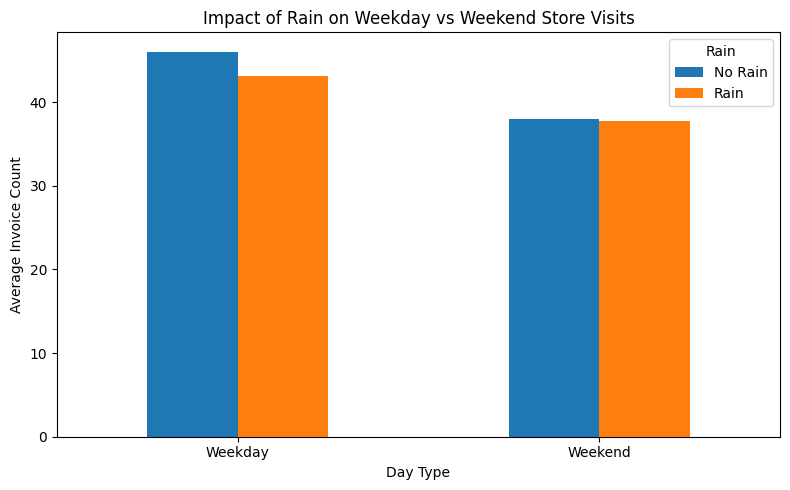

In [32]:
interaction_plot = (
    df_merged
    .groupby(["is_weekend", "is_rain"])["invoice_count"]
    .mean()
    .unstack()
)

interaction_plot.plot(kind="bar", figsize=(8,5))
plt.title("Impact of Rain on Weekday vs Weekend Store Visits")
plt.xlabel("Day Type")
plt.ylabel("Average Invoice Count")
plt.xticks([0,1], ["Weekday", "Weekend"], rotation=0)
plt.legend(["No Rain", "Rain"], title="Rain")
plt.tight_layout()
plt.show()